# Cartea-Jaimungal agent vs RL agent

### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics

### Create market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [25]:
def get_cj_env(num_trajectories:int = 1):
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = CjMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [26]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_cj_env(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [27]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ.zip"

### Define PPO policy

In [28]:
policy_kwargs = dict(
    net_arch=[
        dict(
            pi=[256, 256],
            vf=[256, 256]

            # pi=[64, 64],
            # vf=[64, 64]
        )
    ]
)

PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": 1_000_000, 
              "n_steps": int(n_steps)}

callback_params = dict(eval_env=sb_env, n_eval_episodes = 128, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [29]:
# Train model or load pretrained

OVERWRITE = False

if OVERWRITE or not os.path.isfile(best_model_path):
    print("Training from scratch")
    model.learn(
        # total_timesteps = 10_000,
        # total_timesteps = 100_000,
        # total_timesteps = 1_000_000,
        total_timesteps = 10_000_000,
        # callback = callback,
    )  # Increase number of training timesteps according to computing resources
    model.save(best_model_path)
else:
    print("Loading best model")
    model = PPO.load(best_model_path)
    model.env = sb_env

Training from scratch
Logging to ./tensorboard/PPO-learning-CJ/PPO_9
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -4.362028 |
| time/              |           |
|    fps             | 155906    |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 100000    |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.4517148   |
| time/                   |              |
|    fps                  | 22878        |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0015495528 |
|    clip_fraction        | 0.002        |
|    clip_range           | 0.2          |
|    entropy_loss     

## Comparing the learnt policy to the optimal policy

In [30]:
from mbt_gym.agents.SbAgent import SbAgent

In [31]:
ppo_agent = SbAgent(model)

In [32]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5]])).reshape(-1)
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [33]:
cj_agent = CarteaJaimungalMmAgent(env=get_cj_env())

In [34]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

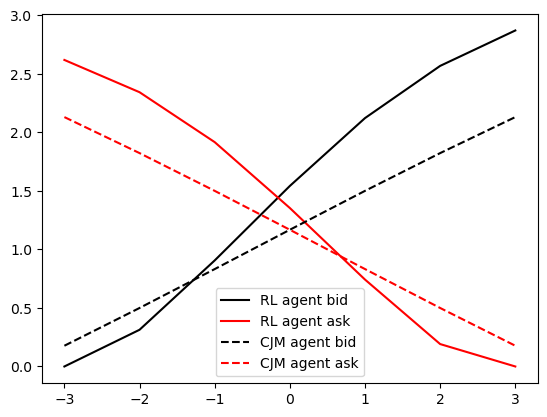

In [35]:
plt.plot(inventories, bid_actions, label = "RL agent bid", color = "k")
plt.plot(inventories, ask_actions, label = "RL agent ask", color = "r")
plt.plot(inventories, cj_bid_actions, label = "CJM agent bid", color = "k", linestyle = "--")
plt.plot(inventories, cj_ask_actions, label = "CJM agent ask", color = "r", linestyle = "--")
plt.legend()

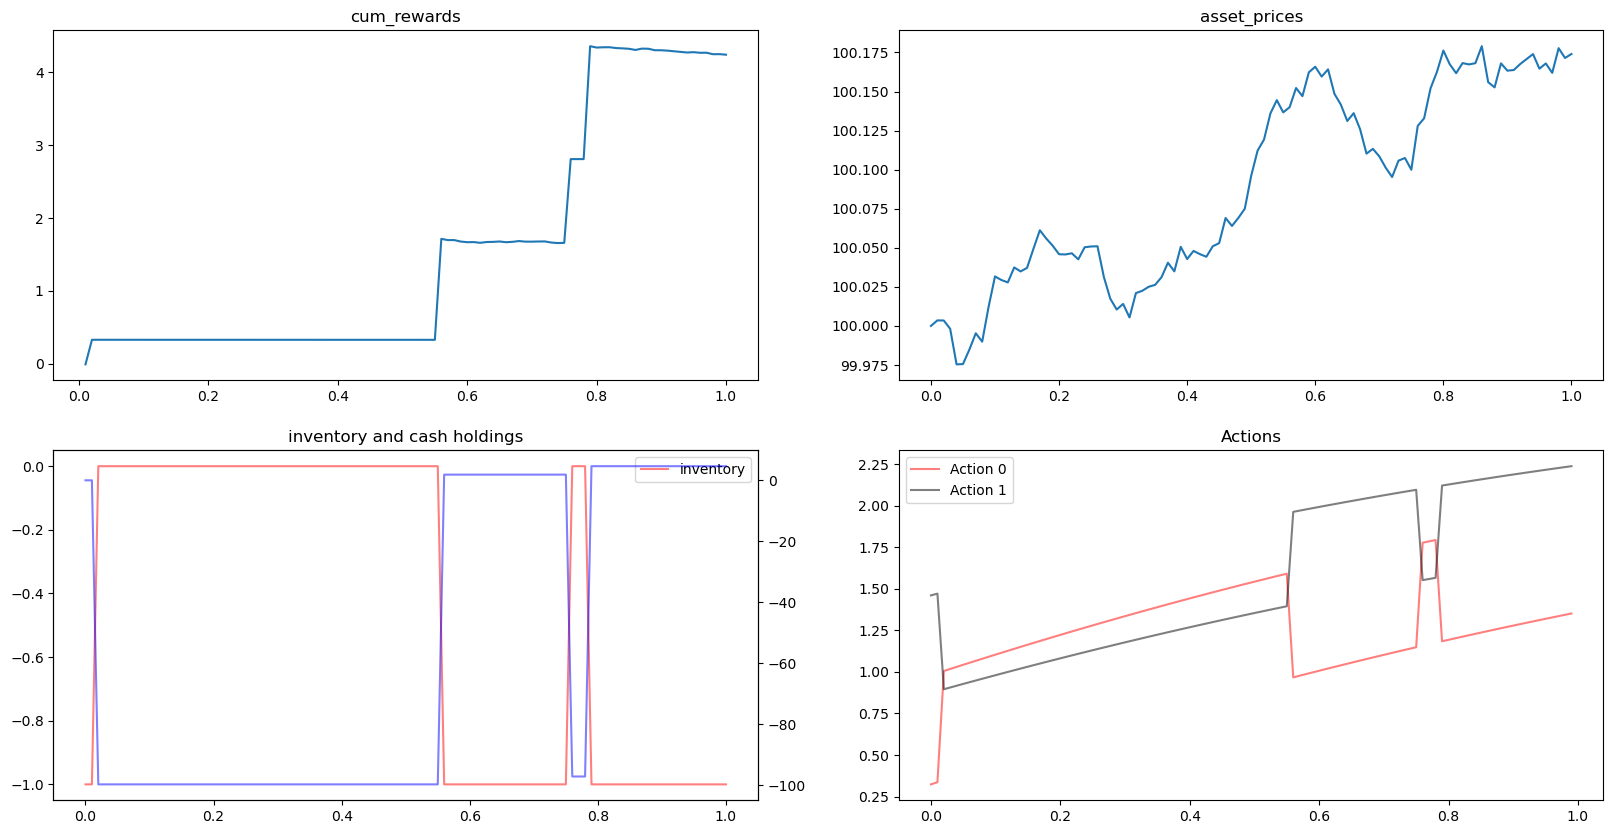

In [36]:
from mbt_gym.gym.index_names import INVENTORY_INDEX, TIME_INDEX
from mbt_gym.agents.SbAgent import SbAgent
from mbt_gym.gym.helpers.plotting import plot_trajectory

# environment containing the full state [cash, inventory, time, price, …]
full_env = get_cj_env(num_trajectories=1)

# PPO was trained on the reduced state, so drop the unused columns before predict()
ppo_agent = SbAgent(model, reduced_training_indices=[INVENTORY_INDEX, TIME_INDEX])

plot_trajectory(full_env, ppo_agent, seed=24)     # no IndexError

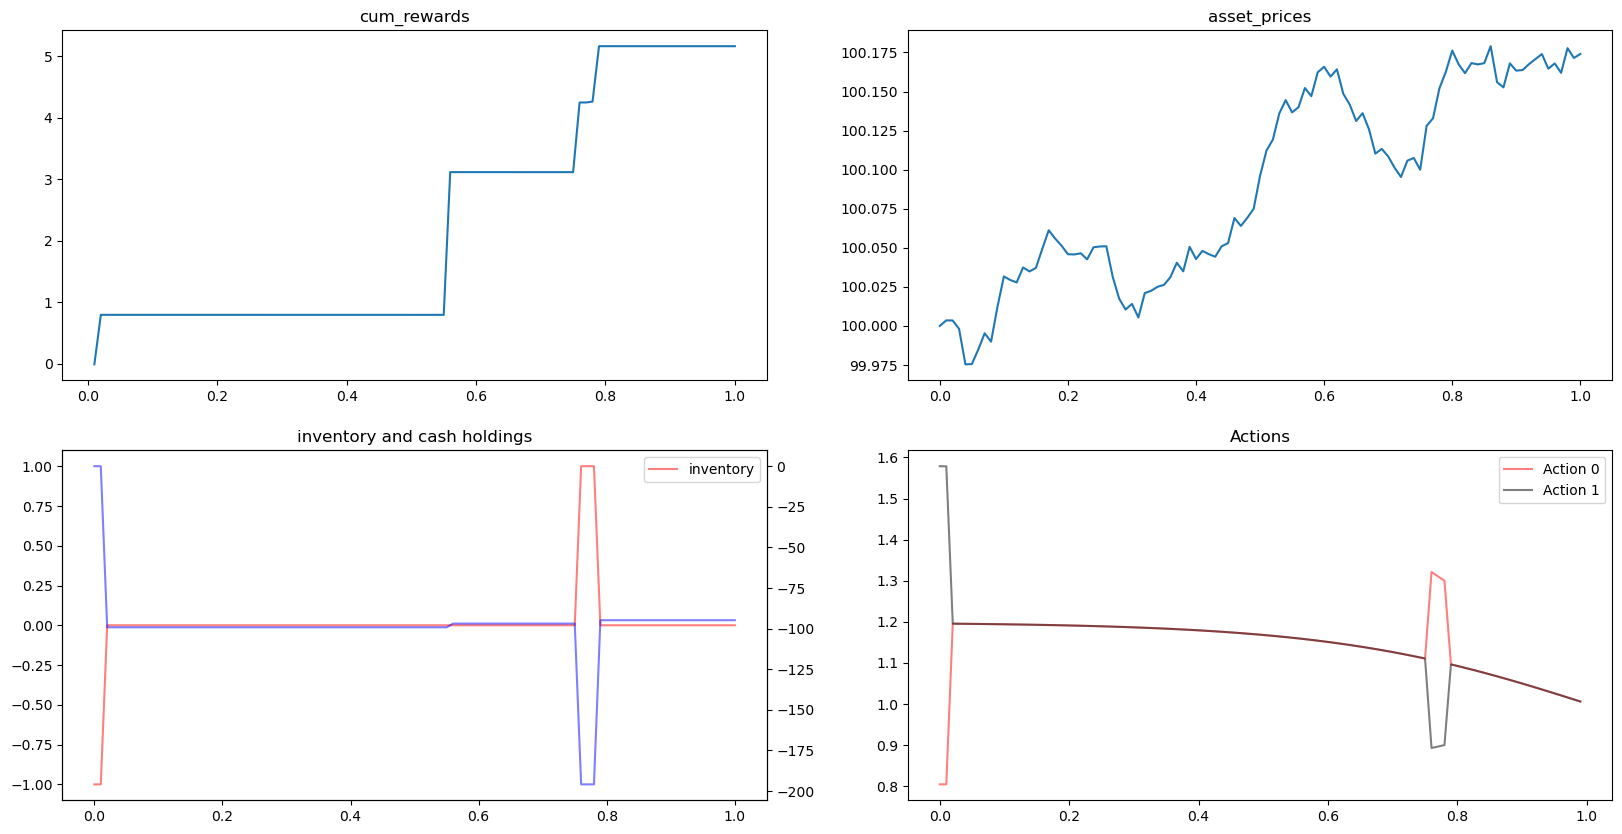

In [37]:
from mbt_gym.gym.helpers.plotting import *

plot_trajectory(full_env, cj_agent, seed=24)     # no IndexError